## Read sklearn and the yellow toolbox

In [1]:
yellow_follow = 'C:/Users/caspe/Desktop/yellow/lib'

import sys; sys.path.append(yellow_follow) 
import sqlite3
import pandas as pd
import ml_utils
import numpy as np
import math

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.constraints import max_norm

## Load datasets and scale them

In [3]:
# Local folder
folder = "C:/Users/caspe/Desktop/Paper_2_StructuralVolume/raw/"

in_path = folder + "buildings.sqlite"

db_cnx = sqlite3.connect(in_path)

df = pd.read_sql_query("SELECT * FROM 'buildings' WHERE buildings.area_vol_ratio >= 1 AND buildings.vol_sum > 1 ORDER BY RANDOM();", db_cnx)
df['pred_vol'] = np.nan

scaler = StandardScaler()
cols = ['area', 'perimeter', 'ipq']

In [4]:
# What is the mean building size?
df['vol_sum'].mean()

522.8423209885111

In [5]:
# What is the mean building size?
df['vol_sum'].median()

178.02704305648808

In [6]:
# How many are taken out for reevaluation?
df_total = pd.read_sql_query("SELECT * FROM 'buildings' WHERE buildings.area_vol_ratio < 1 OR buildings.vol_sum <= 1;", db_cnx)
print(f"Total out out sync: {len(df_total)}")
print(f"Total: {len(df)}")
print(f"Percent: {round((len(df_total) / len(df)) * 100, 2)}")
del df_total

Total out out sync: 125547
Total: 1674270
Percent: 7.5


In [7]:
# Ready the traning data
x = df_scaled = scaler.fit_transform(df[cols])
y = df[['vol_sum']].values

In [8]:
# Create a balance mask, to ensure the classes are balanced
labels = [50, 150, 300, 500, 800]
truth_labels = np.rot90(np.digitize(y, labels))[0]
freq = ml_utils.count_freq(truth_labels)
minority = freq.min(axis=0)[1]
balance_mask = ml_utils.minority_class_mask(truth_labels, minority)

## Investigate the classes

In [9]:
freq

array([[     0, 402273],
       [     1, 383556],
       [     2, 203936],
       [     3, 212904],
       [     4, 237773],
       [     5, 233828]], dtype=int64)

In [10]:
X = x[balance_mask]
Y = y[balance_mask]
Y_class = truth_labels[balance_mask]

# Deep Learning step

In [10]:
# Define model
def define_model(shape, name, maxnorm=4, drop=0.1):
    model_input = Input(shape=shape, name="input")
    model = Dense(64, activation=tfa.activations.mish, kernel_initializer="he_uniform", kernel_constraint=max_norm(maxnorm), bias_constraint=max_norm(maxnorm))(model_input)
    model = Dropout(drop)(model)
    model = Dense(32, activation=tfa.activations.mish, kernel_initializer="he_uniform", kernel_constraint=max_norm(maxnorm), bias_constraint=max_norm(maxnorm))(model)
    model = Dropout(drop)(model)
    model = Dense(16, activation=tfa.activations.mish, kernel_initializer="he_uniform", kernel_constraint=max_norm(maxnorm), bias_constraint=max_norm(maxnorm))(model)
    model = Dropout(drop)(model)
    model = Dense(8, activation=tfa.activations.mish, kernel_initializer="he_uniform", kernel_constraint=max_norm(maxnorm), bias_constraint=max_norm(maxnorm))(model)

    predictions = Dense(1, activation="relu", dtype="float32")(model)

    return Model(inputs=[model_input], outputs=predictions)

In [11]:
lr = 0.01
bs = 1024
epochs = 50

def step_decay(epoch):
    initial_lrate = lr
    drop = 0.5
    epochs_drop = 3
    lrate = initial_lrate * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lrate

In [12]:
# Scores for the kfolds
scores =  {
    "mean_absolute_error": [],
    "mean_absolute_percentage_error": [],
    "median_absolute_error": [],
    "median_absolute_percentage_error": [],
}

skf = StratifiedShuffleSplit(n_splits=1, test_size=0.1, train_size=0.5, random_state=42)

for train_index, test_index in skf.split(x, truth_labels):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    shape = X_train.shape[1]
    model = define_model(shape, "input")

    # Compile and test model
    model.compile(
        optimizer=Adam(
            learning_rate=lr,
            name="Adam",
        ),
        loss='log_cosh',
        metrics=[
            "mean_absolute_error",
            "mean_absolute_percentage_error",
            ml_utils.median_absolute_error,
            ml_utils.median_absolute_percentage_error,
        ])

    model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        verbose=1,
        batch_size=bs,
        validation_split=0.2,
        callbacks=[
            LearningRateScheduler(step_decay),
            EarlyStopping(
                monitor="val_loss",
                patience=9,
                min_delta=1.0,
                restore_best_weights=True,
            ),
        ]
    )

    # Evaluate model
    loss, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, median_absolute_percentage_error = model.evaluate(X_test, y_test, verbose=1)

    scores["mean_absolute_error"].append(mean_absolute_error)
    scores["mean_absolute_percentage_error"].append(mean_absolute_percentage_error)
    scores["median_absolute_error"].append(median_absolute_error)
    scores["median_absolute_percentage_error"].append(median_absolute_percentage_error)

Epoch 1/50
655/655 [==============================] - 29s 35ms/step - loss: 228.2878 - mean_absolute_error: 228.9725 - mean_absolute_percentage_error: 84.2177 - median_absolute_error: 68.8696 - median_absolute_percentage_error: 42.3163 - val_loss: 143.8360 - val_mean_absolute_error: 144.5126 - val_mean_absolute_percentage_error: 28.4007 - val_median_absolute_error: 26.7714 - val_median_absolute_percentage_error: 19.9145
Epoch 2/50
655/655 [==============================] - 21s 32ms/step - loss: 138.5474 - mean_absolute_error: 139.2263 - mean_absolute_percentage_error: 32.2886 - median_absolute_error: 32.1870 - median_absolute_percentage_error: 21.8229 - val_loss: 134.9921 - val_mean_absolute_error: 135.6694 - val_mean_absolute_percentage_error: 28.9777 - val_median_absolute_error: 26.3492 - val_median_absolute_percentage_error: 19.1885
Epoch 3/50
655/655 [==============================] - 21s 33ms/step - loss: 137.5141 - mean_absolute_error: 138.1915 - mean_absolute_percentage_error: 3

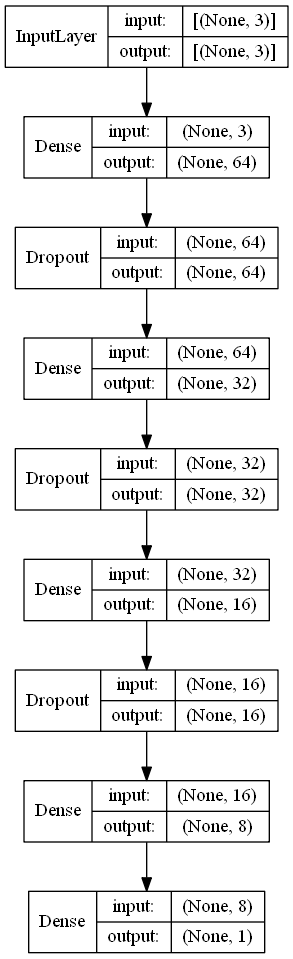

In [13]:
plot_model(model, to_file="./buildings_model_02.png", show_shapes=True, show_dtype=False, show_layer_names=False)

In [14]:
# scores
mae_mean = np.array(scores['mean_absolute_error']).mean()
mae_std = np.array(scores['mean_absolute_error']).std()

mape_mean = np.array(scores['mean_absolute_percentage_error']).mean()
mape_std = np.array(scores['mean_absolute_percentage_error']).std()

meae_mean = np.array(scores['median_absolute_error']).mean()
meae_std = np.array(scores['median_absolute_error']).std()

meape_mean = np.array(scores['median_absolute_percentage_error']).mean()
meapee_std = np.array(scores['median_absolute_percentage_error']).std()


print(f"    Combined Score:")
print(f"    Mean Absolute Error (MAE):               {ml_utils.pad(str(round(mae_mean, 3)), 5, 3)} ({ml_utils.pad(str(round(mae_std, 3)), 5, 3)} stdev)")
print(f"    Mean Absolute Percentage Error (MAPE):   {ml_utils.pad(str(round(mape_mean, 3)), 5, 3)} ({ml_utils.pad(str(round(mape_std, 3)), 5, 3)} stdev)")
print(f"    Median Absolute Error (MeAE):            {ml_utils.pad(str(round(meae_mean, 3)), 5, 3)} ({ml_utils.pad(str(round(meae_std, 3)), 5, 3)} stdev)")
print(f"    Median Absolute Percentage Error (MAPE): {ml_utils.pad(str(round(meape_mean, 3)), 5, 3)} ({ml_utils.pad(str(round(meapee_std, 3)), 5, 3)} stdev)")
print("")

    Combined Score:
    Mean Absolute Error (MAE):                 133.737 (    0.000 stdev)
    Mean Absolute Percentage Error (MAPE):      27.843 (    0.000 stdev)
    Median Absolute Error (MeAE):               29.299 (    0.000 stdev)
    Median Absolute Percentage Error (MAPE):    18.571 (    0.000 stdev)



In [ ]:
    # Combined Score:
    # Mean Absolute Error (MAE):                 128.722 (    1.369 stdev)
    # Mean Absolute Percentage Error (MAPE):      25.092 (    0.368 stdev)
    # Median Absolute Error (MeAE):               29.269 (    0.618 stdev)
    # Median Absolute Percentage Error (MAPE):    17.772 (    0.111 stdev)

    # Combined Score:
    # Mean Absolute Error (MAE):                 127.673 (    0.000 stdev)
    # Mean Absolute Percentage Error (MAPE):      26.473 (    0.000 stdev)
    # Median Absolute Error (MeAE):               30.227 (    0.000 stdev)
    # Median Absolute Percentage Error (MAPE):    18.060 (    0.000 stdev)

In [ ]:
# Run model on whole set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y_class)

shape = X_train.shape[1]
model = define_model(shape, "input")

# Compile and test model
model.compile(
    optimizer=define_optimizer(),
    loss='mean_absolute_error',
    metrics=[
        "mean_absolute_error",
        "mean_absolute_percentage_error",
        ml_utils.median_absolute_error,
        ml_utils.median_absolute_percentage_error,
    ])

model.fit(
    x=X_train,
    y=y_train,
    epochs=100,
    verbose=1,
    batch_size=1024,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=9,
            min_delta=1.0,
            restore_best_weights=True,
        ),
    ]
)

In [ ]:
# Evaluate model
loss, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, median_absolute_percentage_error = model.evaluate(X_test, y_test, verbose=1)
print("Test accuracy:")

print(f"Mean Absolute Error (MAE):                 {ml_utils.pad(str(round(mean_absolute_error, 3)), 3, 3)}")
print(f"Mean Absolute Percentage Error (MAPE):     {ml_utils.pad(str(round(mean_absolute_percentage_error, 3)), 3, 3)}")
print(f"Median Absolute Error (MAE):               {ml_utils.pad(str(round(median_absolute_error, 3)), 3, 3)}")
print(f"Median Absolute Percentage Error (MeAPE):  {ml_utils.pad(str(round(median_absolute_percentage_error, 3)), 3, 3)}")

Test accuracy:
Mean Absolute Error (MAE):                 153.878
Mean Absolute Percentage Error (MAPE):      24.493
Median Absolute Error (MAE):                44.903
Median Absolute Percentage Error (MeAPE):   17.986

In [ ]:
# Lets add it back to the original data and visually inspect the results
df = pd.read_sql_query("SELECT * FROM 'buildings' ORDER BY RANDOM();", db_cnx)

scaler = StandardScaler()
cols = ['area', 'perimeter', 'ipq']

x = df_scaled = scaler.fit_transform(df[cols])

pred = model.predict(x)

In [ ]:
# Add the predictions back to the list
df['pred_vol'] = pred
df['abs_p_err'] = (abs(df['vol_sum'] - df['pred_vol'])) / df['vol_sum']

# The original volume if it works, otherwise the infered volume.
df['use_vol'] = df['vol_sum']
df.loc[(df['area_vol_ratio'] < 1) | (df['vol_sum'] < 1), 'use_vol'] = df['pred_vol']

In [ ]:
# Set the error to -1 when it's an infered value
df.loc[(df['area_vol_ratio'] < 1) | (df['vol_sum'] < 1), 'abs_p_err'] = -1

In [ ]:
from sqlalchemy import create_engine

engine = create_engine('sqlite:///C:/Users/caspe/Desktop/Paper_2_StructuralVolume/buildings/buildings_pred.sqlite', echo=True)
sqlite_connection = engine.connect()

df.to_sql('buildings_pred', sqlite_connection, if_exists='fail')
sqlite_connection.close()